In [1]:
import requests
import dotenv
import os
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import json
# Load environment variables from .env file
dotenv.load_dotenv()

True

In [2]:
#read OURA_PAT from environment variables
OURA_PAT = os.getenv("OURA_PAT")

In [3]:
import requests 
url = 'https://api.ouraring.com/v2/usercollection/heartrate' 

headers = { 
  'Authorization': f'Bearer {OURA_PAT}' 
}

start_year = 2021
end_year = 2025

current_start_date = date(start_year, 11, 1)
overall_end_date = date(end_year, 7, 25)

pbar = tqdm(total=(overall_end_date - current_start_date).days // 30 + 1, desc="Fetching Heart Rate Data")

all_data = []

print("starting to fetch heart rate data...")
while current_start_date < overall_end_date:
    current_end_date = current_start_date + relativedelta(months=1) - timedelta(days=1)
    
    if current_end_date > overall_end_date:
        current_end_date = overall_end_date
    params = {
        'start_datetime': current_start_date.strftime('%Y-%m-%dT%H:%M:%S-08:00'),
        'end_datetime': current_end_date.strftime('%Y-%m-%dT%H:%M:%S-08:00')
    }

    response = requests.request('GET', url, headers=headers, params=params)
    response_json = response.json()
    pbar.update(1)

    #update current_start_date to the next month
    

    if 'data' in response_json:
      #save data to json
      file_name = f"data/heartrate_{current_start_date.strftime('%Y-%m-%d')}_to_{current_end_date.strftime('%Y-%m-%d')}.json"
      with open(file_name, 'w') as f:
          json.dump(response_json['data'], f, indent=4)
      
      all_data.extend(response_json['data'])
    else:
      print(f"No data for period: {current_start_date} to {current_end_date}")

    current_start_date = current_end_date + timedelta(days=1)

Fetching Heart Rate Data:   0%|          | 0/46 [00:00<?, ?it/s]

starting to fetch heart rate data...


Fetching Heart Rate Data:  98%|█████████▊| 45/46 [01:56<00:04,  4.77s/it]

In [96]:
#convert to pandas dataframe
heart_rate_df = pd.DataFrame(all_data)

In [97]:
heart_rate_df 

,bpm,source,timestamp
0,73,awake,2021-11-17T16:46:57+00:00
1,64,live,2021-11-17T16:47:07+00:00
2,62,awake,2021-11-17T16:47:24+00:00
3,63,awake,2021-11-17T16:47:26+00:00
4,61,live,2021-11-17T16:47:38+00:00
...,...,...,...
789526,80,awake,2025-07-25T07:52:32+00:00
789527,86,awake,2025-07-25T07:53:05+00:00
789528,105,awake,2025-07-25T07:58:02+00:00
789529,94,awake,2025-07-25T07:58:11+00:00


In [98]:
#check if there are any missing dates in the data
heart_rate_df['date'] = pd.to_datetime(heart_rate_df['timestamp'])

#sort by date
heart_rate_df = heart_rate_df.sort_values(by='date')

In [99]:
#create new column 'time_since_last_entry' 
heart_rate_df['time_since_last_entry'] = heart_rate_df['date'].diff().dt.seconds.fillna(0)

In [100]:
#create moving average for bpm 
heart_rate_df['bpm_moving_average'] = heart_rate_df['bpm'].rolling(window=30, min_periods=1).mean()

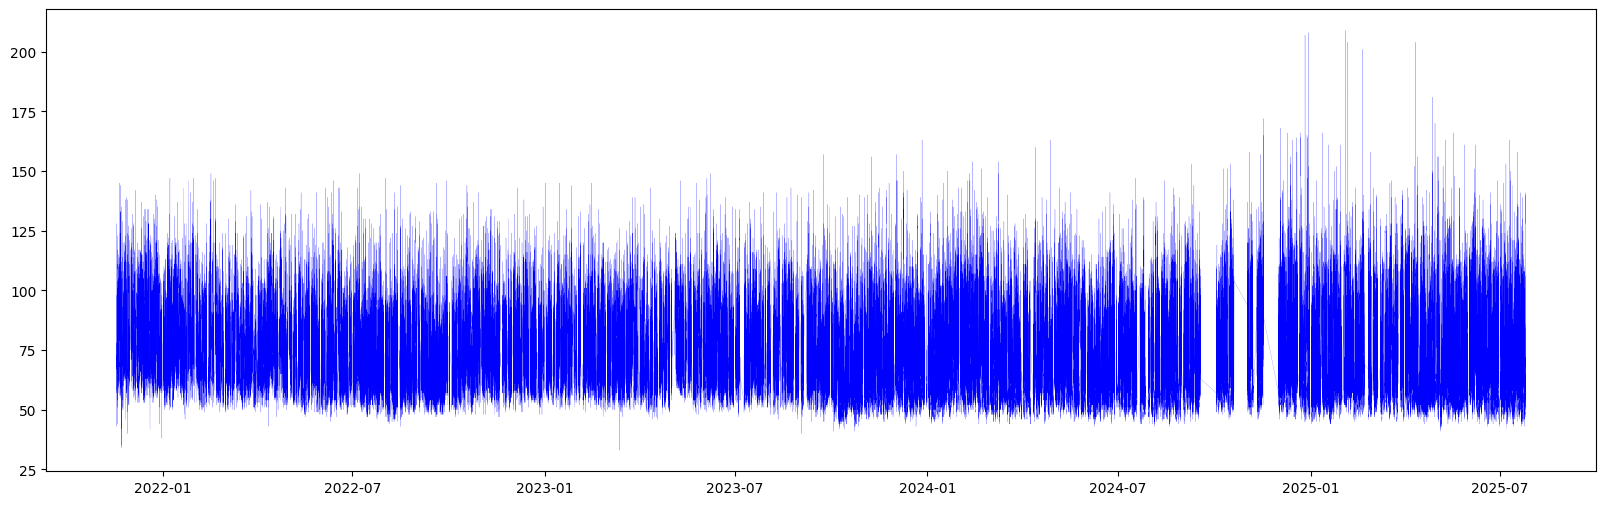

In [28]:
#plot heart rate data
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(heart_rate_df['date'], heart_rate_df['bpm'], label='Average Heart Rate', color='blue', linewidth=0.1)

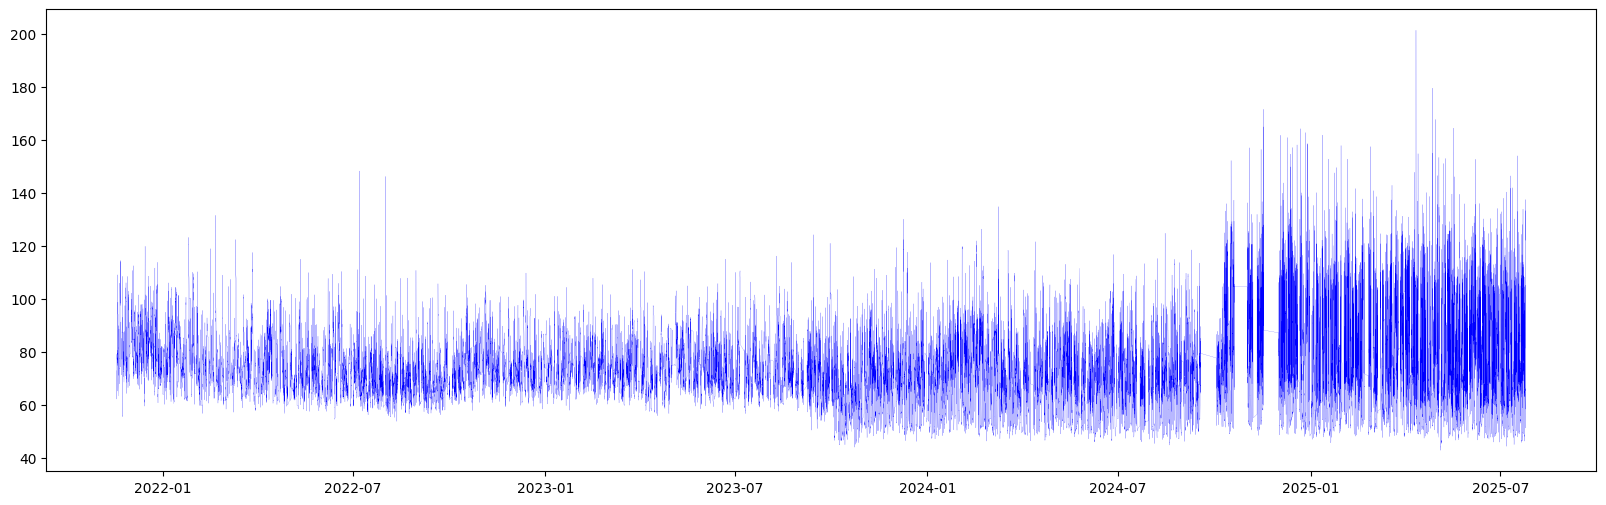

In [30]:
#plot heart rate data
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(heart_rate_df['date'], heart_rate_df['bpm_moving_average'], label='Average Heart Rate', color='blue', linewidth=0.1)

In [101]:
#use the bpm to find outliers 
percentile = heart_rate_df['bpm'].quantile(0.9999)
outliers = heart_rate_df[heart_rate_df['bpm'] > percentile]

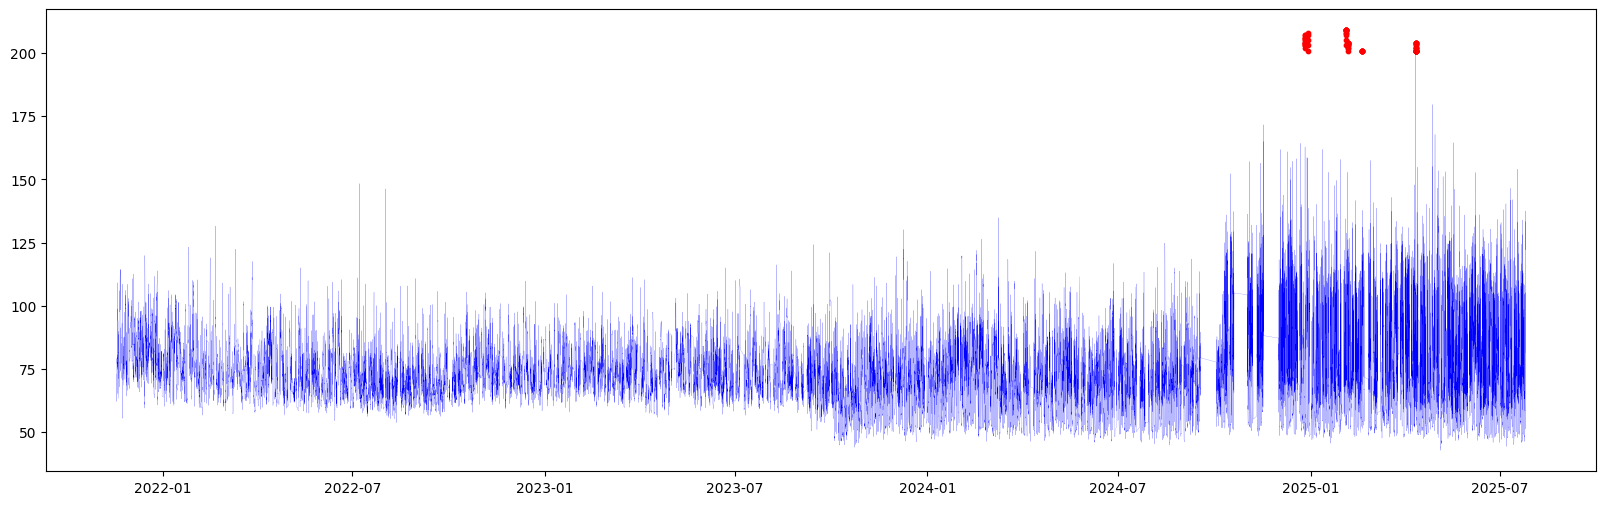

In [63]:
#plot outliers on top of the heart rate data
plt.figure(figsize=(20, 6))
ax = plt.plot(heart_rate_df['date'], heart_rate_df['bpm_moving_average'], label='Average Heart Rate', color='blue', linewidth=0.1)
plt.scatter(outliers['date'], outliers['bpm'], color='red', label='Outliers', s=10)


In [102]:
day_month_year = outliers['date'].dt.strftime('%Y-%m-%d').value_counts().sort_index()

In [103]:
day_month_year.sort_index(inplace=True)
day_month_year

date
2024-12-26    15
2024-12-29     5
2025-02-03    12
2025-02-05    12
2025-02-19     6
2025-04-11    21
Name: count, dtype: int64

In [104]:
#resample bpm data to hourly frequency
heart_rate_df.set_index('date', inplace=True, drop=False)
heart_rate_hourly_mean = heart_rate_df['bpm'].resample('h').mean().reset_index().rename(columns={'bpm': 'average_bpm'})
heart_rate_hourly_min = heart_rate_df['bpm'].resample('h').min().reset_index().rename(columns={'bpm': 'min_bpm'})
heart_rate_hourly_max = heart_rate_df['bpm'].resample('h').max().reset_index().rename(columns={'bpm': 'max_bpm'})

#merge hourly data
heart_rate_hourly = pd.merge(heart_rate_hourly_mean, heart_rate_hourly_min, on='date')
heart_rate_hourly = pd.merge(heart_rate_hourly, heart_rate_hourly_max, on='date')


In [105]:
heart_rate_df.head()

,bpm,source,timestamp,date,time_since_last_entry,bpm_moving_average
date,,,,,,
2021-11-17 16:46:57+00:00,73,awake,2021-11-17T16:46:57+00:00,2021-11-17 16:46:57+00:00,0.0,73.000000
2021-11-17 16:47:07+00:00,64,live,2021-11-17T16:47:07+00:00,2021-11-17 16:47:07+00:00,10.0,68.500000
2021-11-17 16:47:24+00:00,62,awake,2021-11-17T16:47:24+00:00,2021-11-17 16:47:24+00:00,17.0,66.333333
2021-11-17 16:47:26+00:00,63,awake,2021-11-17T16:47:26+00:00,2021-11-17 16:47:26+00:00,2.0,65.500000
2021-11-17 16:47:38+00:00,61,live,2021-11-17T16:47:38+00:00,2021-11-17 16:47:38+00:00,12.0,64.600000


In [106]:
heart_rate_df.source.unique()

array(['awake', 'live', 'workout', 'rest'], dtype=object)

In [121]:
#resample bpm data to daily frequency
heart_rate_df_awake = heart_rate_df[heart_rate_df['source'] != 'rest']

heart_rate_daily_mean = heart_rate_df_awake['bpm'].resample('D').mean().reset_index().rename(columns={'bpm': 'average_bpm'})
heart_rate_daily_min = heart_rate_df_awake['bpm'].resample('D').min().reset_index().rename(columns={'bpm': 'min_bpm'})
heart_rate_daily_max = heart_rate_df_awake['bpm'].resample('D').max().reset_index().rename(columns={'bpm': 'max_bpm'})

#merge daily data
heart_rate_daily_awake = pd.merge(heart_rate_daily_mean, heart_rate_daily_min, on='date')
heart_rate_daily_awake = pd.merge(heart_rate_daily_awake, heart_rate_daily_max, on='date')



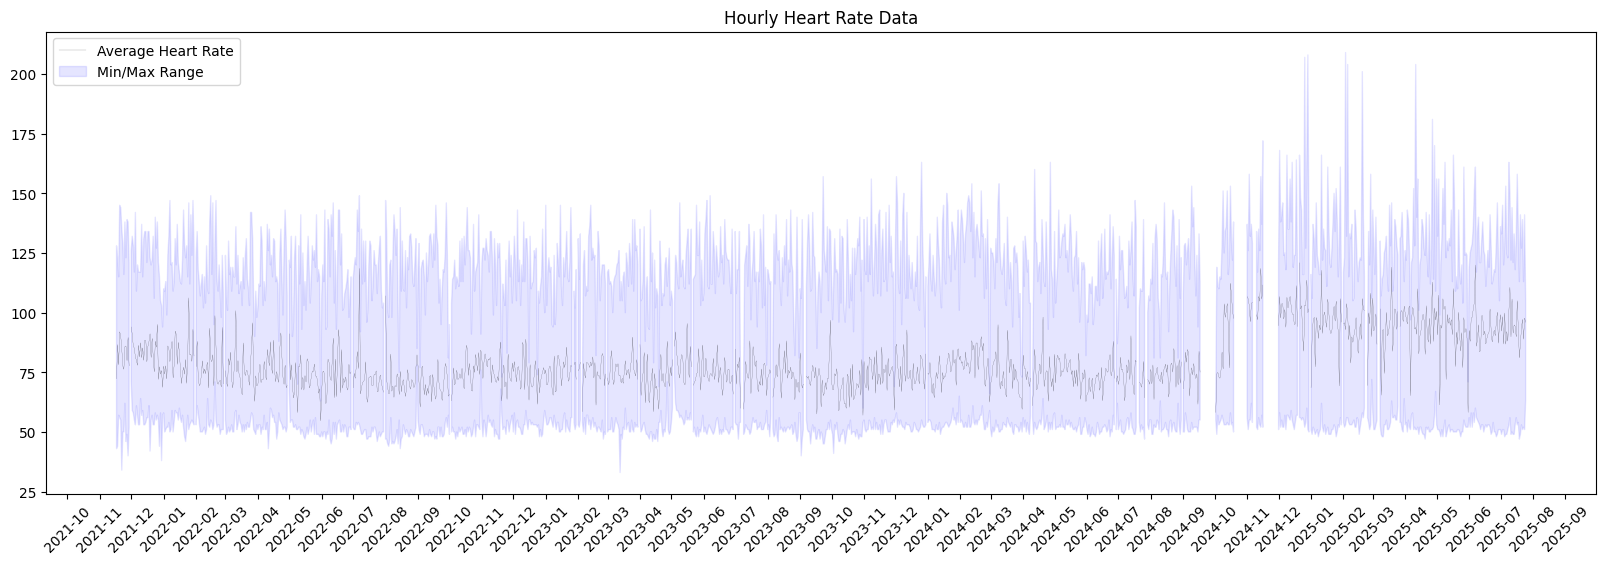

In [136]:
import matplotlib.dates as mdates

# Plot hourly data
plt.figure(figsize=(20, 6))
plt.plot(heart_rate_daily_awake['date'], heart_rate_daily_awake['average_bpm'], label='Average Heart Rate', color='k', linewidth=0.1)
plt.fill_between(heart_rate_daily_awake['date'], heart_rate_daily_awake['min_bpm'], heart_rate_daily_awake['max_bpm'], color='blue', alpha=0.1, label='Min/Max Range')

# Format x-axis to show monthly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis ticks
plt.xticks(rotation=45)

plt.title('Hourly Heart Rate Data')
plt.legend()
plt.show()


In [132]:
#subset to a single date 07-20-2025
single_date = heart_rate_df[heart_rate_df['date'].dt.date == date(2022, 7, 10)].copy()

In [133]:
single_date['time_of_day'] = single_date['date'].dt.hour + single_date['date'].dt.minute / 60

In [134]:
single_date.source.unique()

array(['awake'], dtype=object)

In [124]:
#resample bpm data to daily frequency
hear_rate_df_rest = heart_rate_df[heart_rate_df['source'] == 'rest']

heart_rate_daily_rest_mean = hear_rate_df_rest['bpm'].resample('D').mean().reset_index().rename(columns={'bpm': 'average_bpm'})
heart_rate_daily_rest_min = hear_rate_df_rest['bpm'].resample('D').min().reset_index().rename(columns={'bpm': 'min_bpm'})
heart_rate_daily_rest_max = hear_rate_df_rest['bpm'].resample('D').max().reset_index().rename(columns={'bpm': 'max_bpm'})

#merge daily data
heart_rate_daily_rest = pd.merge(heart_rate_daily_rest_mean, heart_rate_daily_rest_min, on='date')
heart_rate_daily_rest = pd.merge(heart_rate_daily_rest, heart_rate_daily_rest_max, on='date')



Text(0.5, 1.0, 'Hourly Heart Rate Data')

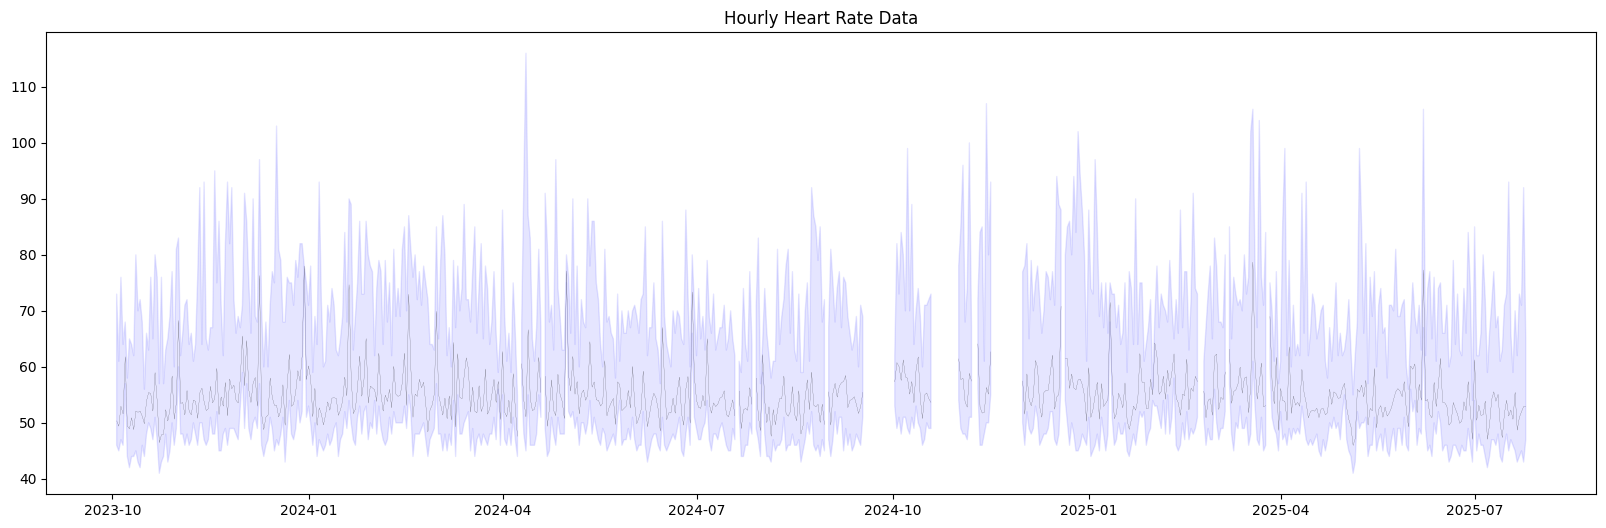

In [126]:
#plot hourly data
plt.figure(figsize=(20, 6))
plt.plot(heart_rate_daily_rest['date'], heart_rate_daily_rest['average_bpm'], label='Average Heart Rate', color='k', linewidth=0.1)
plt.fill_between(heart_rate_daily_rest['date'], heart_rate_daily_rest['min_bpm'], heart_rate_daily_rest['max_bpm'], color='blue', alpha=0.1, label='Min/Max Range')
plt.title('Hourly Heart Rate Data')
